In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.decomposition import PCA

comparison of custom and built-in decision tree with respect to learning rate parameter

In [2]:
large_X_raw = np.load('drive/MyDrive/train.npy', allow_pickle=True)
large_y = pd.read_csv('drive/MyDrive/train_labels.csv')['label'].values

scaler_large = StandardScaler()
large_X = scaler_large.fit_transform(large_X_raw).T  # shape: (features, samples)

In [3]:
df_small = pd.read_csv('drive/MyDrive/optdigits_8x8.csv')
small_X_raw = df_small.iloc[:, :-1].values  # (2200, 64)
small_y = df_small.iloc[:, -1].values       # (2200,)

scaler_small = StandardScaler()
small_X = scaler_small.fit_transform(small_X_raw).T  # shape: (features, samples)

implementation of decision tree

In [6]:
class DecisionTree:
    def __init__(self, columns, depth=None, min_samples_split=2):
        self.max_depth = depth
        self.columns = columns
        self.tree = None
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        data = np.c_[X, y]
        self.tree = self._build_tree(data)

    def predict(self, X):
        return [self._predict_sample(sample, self.tree) for sample in X]

    def _gini_impurity(self, y):
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)

    def _best_split(self, data):
        best_gini = float('inf')
        best_split = None
        n_samples, n_features = data.shape
        y = data[:, -1]

        for feature_index in range(n_features - 1):
            col = data[:, feature_index]
            thresholds = np.percentile(col, [10, 25, 50, 75, 90])
            thresholds = np.unique(thresholds)

            for threshold in thresholds:
                left_mask = col <= threshold
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_split or right_mask.sum() < self.min_samples_split:
                    continue

                left_y = y[left_mask]
                right_y = y[right_mask]

                gini = (len(left_y) * self._gini_impurity(left_y) +
                        len(right_y) * self._gini_impurity(right_y)) / len(y)

                if gini < best_gini:
                    best_gini = gini
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left': data[left_mask],
                        'right': data[right_mask]
                    }

        return best_split

    def _build_tree(self, data, depth=0):
        y = data[:, -1]
        if len(np.unique(y)) == 1:
            return y[0]
        if self.max_depth is not None and depth >= self.max_depth:
            return Counter(y).most_common(1)[0][0]
        if len(y) < self.min_samples_split:
            return Counter(y).most_common(1)[0][0]

        split = self._best_split(data)
        if split is None:
            return Counter(y).most_common(1)[0][0]

        left_subtree = self._build_tree(split['left'], depth + 1)
        right_subtree = self._build_tree(split['right'], depth + 1)

        return {
            'feature_index': split['feature_index'],
            'threshold': split['threshold'],
            'left': left_subtree,
            'right': right_subtree
        }

    def _predict_sample(self, sample, tree):
        if not isinstance(tree, dict):
            return tree
        feature_value = sample[tree['feature_index']]
        if feature_value <= tree['threshold']:
            return self._predict_sample(sample, tree['left'])
        else:
            return self._predict_sample(sample, tree['right'])


In [8]:
depth_range = range(1, 9)

f1_custom_small = []
f1_sklearn_small = []
f1_custom_large = []
f1_sklearn_large = []

pca_small = PCA(n_components=0.95)
X_small_pca = pca_small.fit_transform(small_X.T)
y_small = small_y

pca_large = PCA(n_components=0.95)
X_large_pca = pca_large.fit_transform(large_X.T)
y_large = large_y

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_small_pca, y_small, test_size=0.3, stratify=y_small, random_state=42)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_large_pca, y_large, test_size=0.3, stratify=y_large, random_state=42)

for depth in depth_range:
    print(f"Evaluating depth={depth}")

    # small dataset
    custom_s = DecisionTree(columns=[f"f{i}" for i in range(X_small_pca.shape[1])], depth=depth)
    custom_s.fit(X_train_s, y_train_s)
    preds_c_s = custom_s.predict(X_test_s)
    f1_custom_small.append(f1_score(y_test_s, preds_c_s, average='macro'))

    skl_s = DecisionTreeClassifier(max_depth=depth, random_state=42)
    skl_s.fit(X_train_s, y_train_s)
    preds_s_s = skl_s.predict(X_test_s)
    f1_sklearn_small.append(f1_score(y_test_s, preds_s_s, average='macro'))

    # large dataset
    custom_l = DecisionTree(columns=[f"f{i}" for i in range(X_large_pca.shape[1])], depth=depth)
    custom_l.fit(X_train_l, y_train_l)
    preds_c_l = custom_l.predict(X_test_l)
    f1_custom_large.append(f1_score(y_test_l, preds_c_l, average='macro'))

    skl_l = DecisionTreeClassifier(max_depth=depth, random_state=42)
    skl_l.fit(X_train_l, y_train_l)
    preds_s_l = skl_l.predict(X_test_l)
    f1_sklearn_large.append(f1_score(y_test_l, preds_s_l, average='macro'))

Evaluating depth=1
Evaluating depth=2
Evaluating depth=3
Evaluating depth=4
Evaluating depth=5
Evaluating depth=6
Evaluating depth=7
Evaluating depth=8


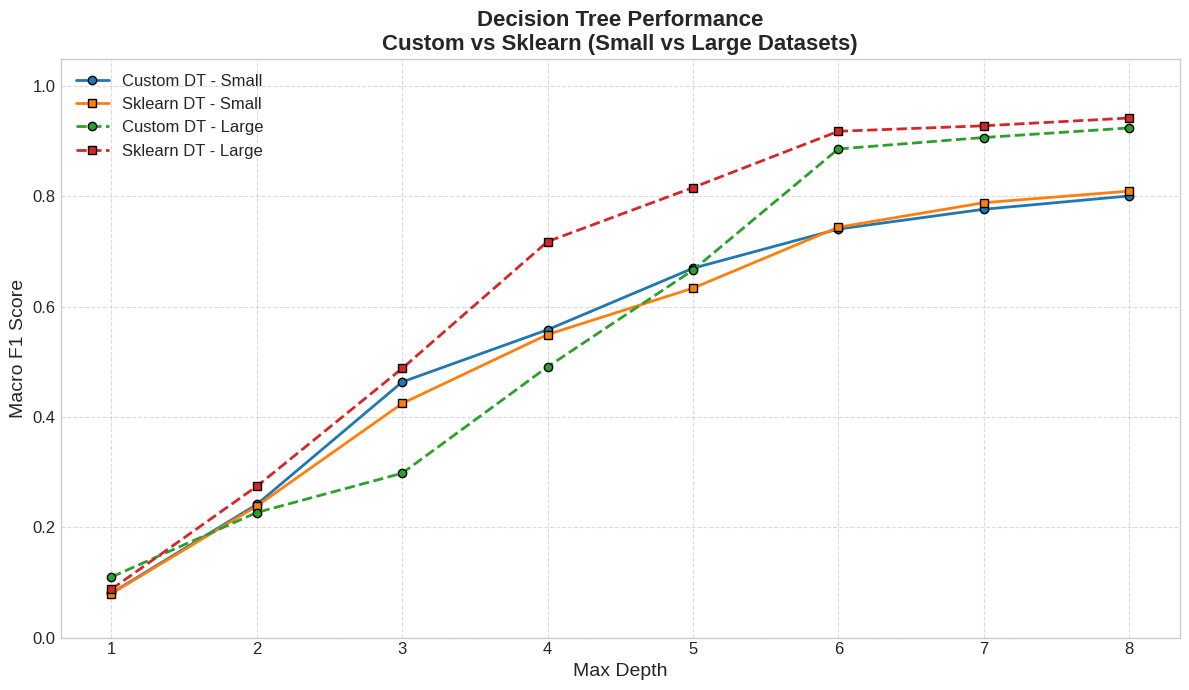

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(depth_range, f1_custom_small, 'o-', label='Custom DT - Small', color='#1f77b4', linewidth=2, markeredgecolor='black')
ax.plot(depth_range, f1_sklearn_small, 's-', label='Sklearn DT - Small', color='#ff7f0e', linewidth=2, markeredgecolor='black')
ax.plot(depth_range, f1_custom_large, 'o--', label='Custom DT - Large', color='#2ca02c', linewidth=2, markeredgecolor='black')
ax.plot(depth_range, f1_sklearn_large, 's--', label='Sklearn DT - Large', color='#d62728', linewidth=2, markeredgecolor='black')

ax.set_xlabel('Max Depth', fontsize=14)
ax.set_ylabel('Macro F1 Score', fontsize=14)
ax.set_title('Decision Tree Performance\nCustom vs Sklearn (Small vs Large Datasets)', fontsize=16, weight='bold')
ax.legend(fontsize=12)
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()